## Question 1:
Is there a statistical difference in the odds of winning a game when a team is playing in front of their home crowd?

## Hypothesis:
**Null Hypothesis** H<sub>0</sub> = There is *no statistical difference* in the odds of winning a game when a team is playing in front of their home crowd 

**Alternative Hypothesis** H<sub>a</sub> = There is *always* a difference in the odds of winning a game when a team is playing in front of their home crowd.

In [167]:
import pandas as pd
import numpy as np
import psycopg2
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
conn = psycopg2.connect('dbname=football_db')

In [3]:
cur = conn.cursor()

In [4]:
columns = ['id', 'home_goal', 'away_goal', 'result']

query = f"""
SELECT match_api_id, home_team_goal, away_team_goal, 
CASE WHEN home_team_goal > away_team_goal THEN 'Win' 
         ELSE 'NoWin' END as Result
FROM Match
"""

cur.execute(query)
data = cur.fetchall()

In [5]:
df = pd.DataFrame(data, columns=columns)

In [6]:
df.head()

,id,home_goal,away_goal,result
0,492473,1,1,NoWin
1,492474,0,0,NoWin
2,492475,0,3,NoWin
3,492476,5,0,Win
4,492477,1,3,NoWin


In [7]:
total_wins = len(df[df['result'] == 'Win'])
total_wins

11917

In [8]:
total_games = len(df['result'])
total_games

25979

In [9]:
# Population mean (μ): Win rate for all home game wins for entire dataset
mu = total_wins / total_games
mu

0.45871665576042187

In [10]:
sample_size = 2000
number_of_games = 2000
samples = np.zeros(sample_size)
for i in range(sample_size):
    """Taking a sample size of the win rate for home games"""
    games = df.iloc[np.random.randint(low=0, high=len(df), size=number_of_games), :]
    win_rate = len(games[games['result'] == 'Win']) / number_of_games
    samples[i] = win_rate


In [11]:
sample_mean = samples.mean()
sample_mean

0.45832500000000004

In [12]:
std = np.std(samples, ddof=1)
std

0.010988926392128838

In [13]:
# T-Test to compare the average mean to the population mean
t = (sample_mean - mu) / (std / np.sqrt(sample_size))
t

-1.593911675866488

In [14]:
# Degrees of Freedom
df = sample_size - 1

### Calculating Critical T-Value
If the test statistic is more extreme than the critical value, then the null hypothesis is rejected in favor of the alternative hypothesis. If the test statistic is not as extreme as the critical value, then the null hypothesis is not rejected.

In [15]:
t_crit = np.round(stats.t.ppf(1 - 0.05, df), 3)
t_crit

1.646

In [16]:
results = stats.ttest_1samp(a=samples, popmean=mu)
print(results)
print('\n')

if (results[0]>t_crit) and (results[1]<0.05):
    print ("Null hypothesis rejected. Results are statistically significant with t-value =", 
           round(results[0], 2), "and p-value =", np.round((results[1]), 4))
else:
    print ("Null hypothesis is Accepted")

Ttest_1sampResult(statistic=-1.593911675866488, pvalue=0.11111390677346769)


Null hypothesis is Accepted


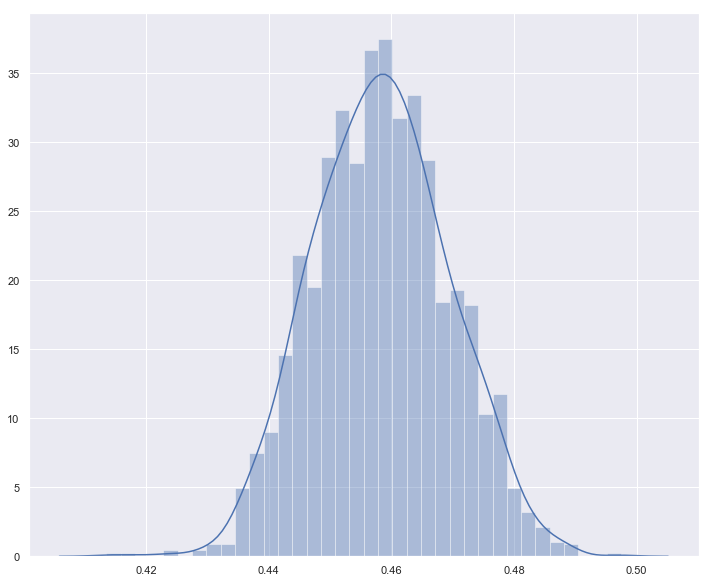

In [18]:
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})
sns.distplot(samples)

## Result:
While limiting alpha to 0.05, The P-value is > 0.05. This concludes that there is no statistical difference when a team wins in front of a home crowd or wins at away games, therefore accepting the null hypothesis.

---

## Question 2:
Is there a statistical difference in the odds of winning a game when the height of a team is taller than the other team?

## Hypothesis:
**Null Hypothesis** H<sub>0</sub> = There is *no statistical difference* in the odds of winning a game dependent on a teams height.

**Alternative Hypothesis** H<sub>a</sub> = There is *always* a difference in the odds of winning a game dependent on a teams height.

In [255]:
conn = psycopg2.connect('dbname=football_db')

In [260]:
cur = conn.cursor()

In [270]:
columns = ['game_date', 'home_height', 'away_height', 'result' ]

query = f"""
select M.date,  
(H1.height + H2.height + H3.height + H4.height + H5.height + H6.height +
H7.height + H8.height + H9.height + H10.height + H11.height) / 11 H_HEIGHT,
(A1.height + A2.height + A3.height + A4.height + A5.height +  A6.height + 
A7.height + A8.height + A9.height + A10.height + A11.height) / 11 A_HEIGHT,
CASE WHEN home_team_goal > away_team_goal THEN 'Win' 
     WHEN home_team_goal = away_team_goal THEN 'Draw'
     ELSE 'Lose' END as Result
from Match M
JOIN Player H1 ON M.home_player_1 = H1.player_api_id
JOIN Player H2 ON M.home_player_2 = H2.player_api_id
JOIN Player H3 ON M.home_player_3 = H3.player_api_id
JOIN Player H4 ON M.home_player_4 = H4.player_api_id
JOIN Player H5 ON M.home_player_5 = H5.player_api_id
JOIN Player H6 ON M.home_player_6 = H6.player_api_id
JOIN Player H7 ON M.home_player_7 = H7.player_api_id
JOIN Player H8 ON M.home_player_8 = H8.player_api_id
JOIN Player H9 ON M.home_player_9 = H9.player_api_id
JOIN Player H10 ON M.home_player_10 = H10.player_api_id
JOIN Player H11 ON M.home_player_11 = H11.player_api_id
JOIN Player A1 ON M.away_player_1 = A1.player_api_id
JOIN Player A2 ON M.away_player_2 = A2.player_api_id
JOIN Player A3 ON M.away_player_3 = A3.player_api_id
JOIN Player A4 ON M.away_player_4 = A4.player_api_id
JOIN Player A5 ON M.away_player_5 = A5.player_api_id
JOIN Player A6 ON M.away_player_6 = A6.player_api_id
JOIN Player A7 ON M.away_player_7 = A7.player_api_id
JOIN Player A8 ON M.away_player_8 = A8.player_api_id
JOIN Player A9 ON M.away_player_9 = A9.player_api_id
JOIN Player A10 ON M.away_player_10 = A10.player_api_id
JOIN Player A11 ON M.away_player_11 = A11.player_api_id
"""

cur.execute(query)
data = cur.fetchall()

In [286]:
df = pd.DataFrame(data, columns=columns)

In [287]:
df.head(5)

,game_date,home_height,away_height,result
0,2009-02-27 00:00:00,184.265455,181.263636,Win
1,2009-03-08 00:00:00,181.032727,184.265455,Lose
2,2009-03-07 00:00:00,184.265455,181.032727,Win
3,2009-03-13 00:00:00,184.265455,183.803636,Win
4,2009-03-14 00:00:00,179.878182,181.494545,Draw


In [298]:
win_df = df[df['result']=='Win']

In [334]:
number_of_games = 1500
sample_df = win_df.iloc[np.random.randint(low=0, high=len(win_df), size=number_of_games), :]

In [335]:
experimental = np.array(sample_df['home_height'])
control = np.array(sample_df['away_height'])

In [336]:
mean_home_height = sample_df['home_height'].mean()
mean_home_height

182.15910181818197

In [337]:
mean_away_height = sample_df['away_height'].mean()
mean_away_height

182.24992606060664

In [338]:
mean_home_height - mean_away_height

-0.09082424242467368

In [66]:
def variance(sample):
    """return the variance of sample list"""
    sample_mean = np.mean(sample)
    return sum([(i - sample_mean) ** 2 for i in sample])

In [67]:
def sample_variance(sample1, sample2):
    """return the variance between two sample"""
    n_1, n_2 = len(sample1), len(sample2)
    var_1, var_2 = variance(sample1), variance(sample2)
    return (var_1 + var_2)/((n_1 + n_2)-2)


In [68]:
def twosample_tstatistic(expr, ctrl):
    """return the t-statistic value between expr, ctrl"""
    exp_mean, ctrl_mean = np.mean(expr), np.mean(ctrl)
    samp_var = sample_variance(expr, ctrl)
    n_e, n_c = len(expr), len(ctrl)
    num = exp_mean - ctrl_mean
    denom = np.sqrt(samp_var * ((1/n_e)+(1/n_c)))
    return num / denom

In [342]:
t_stat = twosample_tstatistic(experimental, control)
t_stat

-1.320395157539636

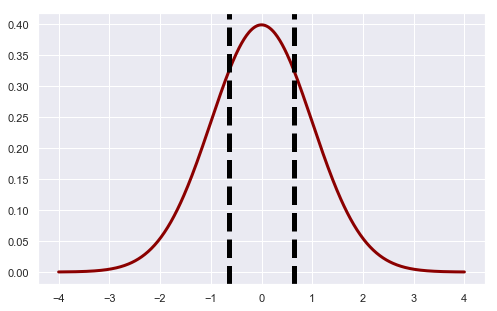

In [71]:
def visualize_t(t_stat, n_control, n_experimental):

    # initialize a matplotlib "figure"
    fig = plt.figure(figsize=(8,5))
    ax = fig.gca()
    # generate points on the x axis between -4 and 4:
    xs = np.linspace(-4, 4, 500)

    # use stats.t.pdf to get values on the probability density function for the t-distribution
    
    ys= stats.t.pdf(xs, (n_control+n_experimental-2), 0, 1)
    ax.plot(xs, ys, linewidth=3, color='darkred')

    ax.axvline(t_stat, color='black', linestyle='--', lw=5)
    ax.axvline(-t_stat, color='black', linestyle='--', lw=5)

    plt.show()
    return None

n_control = len(control)
n_experimental = len(experimental)
visualize_t(t_stat, n_control, n_experimental)


In [344]:
stats.t.sf(abs(t_stat), len(experimental)+len(control)-1) * 2

0.18680387810372373

In [345]:
stats.ttest_ind(experimental, control)

Ttest_indResult(statistic=-1.3203951575396384, pvalue=0.1868039117094079)

## Result:
While limiting alpha to 0.05, The P-value is > 0.05. This concludes that there is no statistical difference when a team wins based on the height of teams players, therefore accepting the null hypothesis.

---

## Question 3:
Is there a statistical difference in the odds of losing a game when the defense pressure of a team is higher than the other team?

## Hypothesis:
**Null Hypothesis** H<sub>0</sub> = There is *no statistical difference* in the odds of losing a game dependent on a teams defense pressure.

**Alternative Hypothesis** H<sub>a</sub> = There is *always* a difference in the odds of losing a game dependent on a teams defense pressure.

In [146]:
conn = psycopg2.connect('dbname=football_db')
cur = conn.cursor()

query = f"""
SELECT M.date,  
CASE WHEN home_team_goal > away_team_goal THEN 'Win' 
     WHEN home_team_goal = away_team_goal THEN 'Draw'
     ELSE 'Lose' END AS result,
T.*,
TT.*
FROM Match M
JOIN Team_Attributes AS T ON M.home_team_api_id = T.team_api_id 
AND SUBSTRING(M.season, 1, 4) = SUBSTRING(T.date, 1, 4)
JOIN Team_Attributes AS TT ON M.away_team_api_id = TT.team_api_id
AND SUBSTRING(M.season, 1, 4) = SUBSTRING(TT.date, 1, 4)

"""
cur.execute(query)
data = cur.fetchall()

In [147]:
df = pd.DataFrame(data)

In [148]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
0,2010-07-31 00:00:00,Win,654,100081,8571,2010-02-22 00:00:00,50,Balanced,NaN,Little,...,45,Normal,Organised,60,Medium,70,Double,70,Wide,Cover
1,2010-07-31 00:00:00,Win,660,110724,8203,2010-02-22 00:00:00,65,Balanced,NaN,Little,...,50,Normal,Organised,65,Medium,65,Press,70,Wide,Cover
2,2010-07-31 00:00:00,Lose,1391,681,10001,2010-02-22 00:00:00,45,Balanced,NaN,Little,...,60,Normal,Organised,45,Medium,50,Press,40,Normal,Cover
3,2010-07-30 00:00:00,Draw,1237,232,9985,2010-02-22 00:00:00,53,Balanced,NaN,Little,...,50,Normal,Organised,70,High,60,Press,70,Wide,Cover
4,2010-08-01 00:00:00,Draw,295,1750,9984,2010-02-22 00:00:00,45,Balanced,NaN,Little,...,60,Normal,Organised,70,High,70,Double,70,Wide,Cover


In [149]:
df = df.drop(range(2,20), axis=1)
df = df.drop(range(21, 27), axis=1)

In [150]:
df = df.drop(range(27, 45), axis=1)
df = df.drop(range(46, 52), axis=1)

In [151]:
df.head()

,0,1,20,45
0,2010-07-31 00:00:00,Win,60,60
1,2010-07-31 00:00:00,Win,60,65
2,2010-07-31 00:00:00,Lose,70,45
3,2010-07-30 00:00:00,Draw,70,70
4,2010-08-01 00:00:00,Draw,65,70


In [153]:
df.columns = ['date',  'result', 'Home_DP', 'Away_DP']
df.head()

,date,result,Home_DP,Away_DP
0,2010-07-31 00:00:00,Win,60,60
1,2010-07-31 00:00:00,Win,60,65
2,2010-07-31 00:00:00,Lose,70,45
3,2010-07-30 00:00:00,Draw,70,70
4,2010-08-01 00:00:00,Draw,65,70


In [324]:
lose_df = df[df['result'] == 'Lose']

In [325]:
len(lose_df)

5041

In [353]:
number_of_games = 300
sample_df = lose_df.iloc[np.random.randint(low=0, 
                                           high=len(lose_df), 
                                           size=number_of_games), :]

In [354]:
experimental = np.array(sample_df['Home_DP'])
control = np.array(sample_df['Away_DP'])

In [355]:
mean_home_dp = experimental.mean()
mean_home_dp

45.81666666666667

In [356]:
mean_away_dp = control.mean()
mean_away_dp

47.92

In [357]:
mean_home_dp - mean_away_dp

-2.1033333333333317

In [358]:
t_stat = twosample_tstatistic(experimental, control)
t_stat

-2.422283722725531

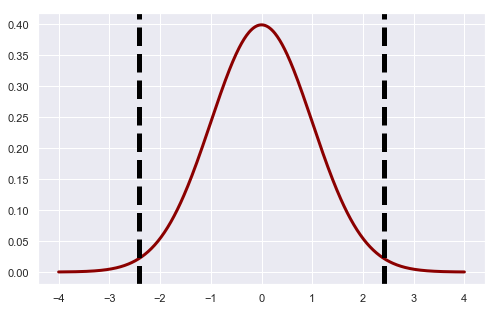

In [359]:
n_control = len(control)
n_experimental = len(experimental)
visualize_t(t_stat, n_control, n_experimental)

In [360]:
stats.t.sf(abs(t_stat), len(experimental)+len(control)-1) * 2

0.015718987067782995

In [361]:
stats.ttest_ind(experimental, control)

Ttest_indResult(statistic=-2.4222837227255303, pvalue=0.015719483172436502)

## Result:
While limiting alpha to 0.05, The P-value is < 0.05. This concludes that there is a statistical difference when a team loses based on the teams' defense pressure, therefore rejecting the null hypothesis.

---

Question 4:
Is there a statistical difference in the odds of losing a game when the defense pressure of a team is higher than the other team?

Hypothesis:
Null Hypothesis H0 = There is no statistical difference in the odds of losing a game dependent on a teams defense pressure.
Alternative Hypothesis Ha = There is always a difference in the odds of losing a game dependent on a teams defense pressure.

In [140]:
conn = psycopg2.connect('dbname=football')
cur = conn.cursor()

query = f"""
SELECT M.date,  
CASE WHEN home_team_goal > away_team_goal THEN 'Win' 
     WHEN home_team_goal = away_team_goal THEN 'Draw'
     ELSE 'Lose' END AS result,
T.buildupplaypassing * T.chancecreationshooting AS Home_Offense,
TT.buildupplaypassing * TT.chancecreationshooting AS Away_Offense
FROM Match M
JOIN Team_Attributes AS T ON M.home_team_api_id = T.team_api_id 
AND SUBSTRING(M.season, 1, 4) = SUBSTRING(T.date, 1, 4)
JOIN Team_Attributes AS TT ON M.away_team_api_id = TT.team_api_id
AND SUBSTRING(M.season, 1, 4) = SUBSTRING(TT.date, 1, 4)
"""

cur.execute(query)
data = cur.fetchall()

In [141]:
df = pd.DataFrame(data)
df.columns = ['date',  'result', 'Home_Offense', 'Away_Offense']
df.head()

,date,result,Home_Offense,Away_Offense
0,2010-07-31 00:00:00,Win,3000,1800
1,2010-07-31 00:00:00,Win,3000,3000
2,2010-07-31 00:00:00,Lose,3300,3900
3,2010-07-30 00:00:00,Draw,2600,3000
4,2010-08-01 00:00:00,Draw,1925,3000


In [142]:
win_df = df[df['result'] == 'Win']

In [143]:
number_of_games = 500
sample_df = win_df.iloc[np.random.randint(low=0, 
                                           high=len(win_df), 
                                           size=number_of_games), :]

In [144]:
experimental = np.array(sample_df['Home_Offense'])
control = np.array(sample_df['Away_Offense'])

In [145]:
mean_home_offence = experimental.mean()
mean_home_offence

2549.504

In [146]:
mean_away_offence = control.mean()
mean_away_offence

2646.636

In [147]:
mean_home_offence - mean_away_offence

-97.13200000000006

In [148]:
t_stat = twosample_tstatistic(experimental, control)
t_stat

-2.02727829827459

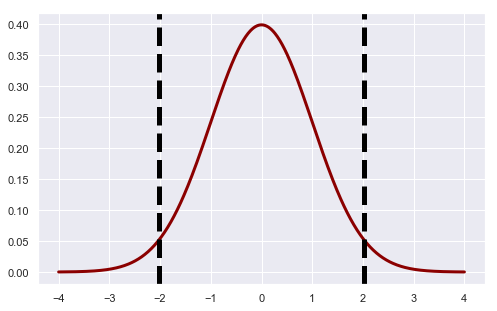

In [149]:
n_control = len(control)
n_experimental = len(experimental)
visualize_t(t_stat, n_control, n_experimental)

In [150]:
stats.t.sf(abs(t_stat), len(experimental)+len(control)-1) * 2

0.04289907035130062

In [151]:
stats.ttest_ind(experimental, control)

Ttest_indResult(statistic=-2.0272782982745903, pvalue=0.042899336136515163)